In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [14]:
#Get the list of US states from one of my files
states=pd.read_csv('states_names.csv')

In [4]:
#states=list(states['State'])

In [5]:
import re

In [6]:
import urllib.request

In [39]:
url

'https://www.countyhealthrankings.org/sites/default/files/state/downloads/2019%20County%20Health%20Rankings%20Ohio%20Data%20-%20v1_0.xls'

In [183]:
for state in ['Alaska', "Hawaii"]:
    x=re.sub(' ', '%20', state)
    url = str('https://www.countyhealthrankings.org/sites/default/files/state/downloads/2019%20County%20Health%20Rankings%20'+x+'%20Data%20-%20v1_0.xls')
    urllib.request.urlretrieve(url, str('States data/'+state+'.xls'))

In [ ]:
import xlrd

In [324]:
df=pd.DataFrame(columns=['fips', 'state', 'county', 'violence rate'])
count=0

In [325]:
for state in states:
    workbook = xlrd.open_workbook(str('States data/'+state+'.xls'), on_demand = True)
    worksheet = workbook.sheet_by_name('Ranked Measure Data')
    
    if ('FIPS' in str(worksheet.cell(1, 0)))&('County' in str(worksheet.cell(1, 2)))&('Violent Crime Rate' in str(worksheet.cell(1, 132))):    
        i=2
        while True:
            try:
                values=[worksheet.cell(i, 0).value, state, worksheet.cell(i, 2).value, worksheet.cell(i, 132).value]
                df.loc[count]=values
                i+=1
                count+=1
            except:
                break
    else:
        print('data is different', state)

In [ ]:
df.fips=pd.Series([str(int(df.fips[i])) for i in df.index], index=df.index)

In [169]:
np.isnan(df.loc[29]['rate'])

True

In [196]:
# replace absecnt values with State average values
nan_index=[ind for ind in df.index if type(df.rate[ind])==float]

In [ ]:
nan_index=[ind for ind in df.index if df.rate[ind]=='0']

In [220]:
for ind in nan_index:
    state_ind=[i for i in df[df.state==df.loc[ind]['state']].index if (type(df.loc[i]['county'])==float)]
    df.loc[ind]['rate']=df.loc[state_ind[0]]['rate']
    #print(state_ind, df.loc[state_ind[0]]['rate'])

C:\Users\vnuretdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['rate']=df['rate'].str.replace(',', '')

In [243]:
df['rate']=df.rate.astype('int64')

In [223]:
df.to_csv("crime_county.csv")

In [411]:
crime_list=list(df[df.county!='']['violence rate'])

In [412]:
crime_list=[x for x in crime_list if type(x)==type(crime_list[0])]

In [404]:
crime_list=crime_list[crime_list!='']

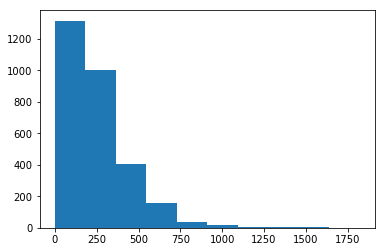

In [421]:
plt.hist(crime_list)
plt.show()

In [492]:
rent_list=list(df[df.county!='']['rent'])

In [493]:
for thr in np.arange(0, 100, 10):
    print(np.percentile(rent_list, thr))

612.0
651.0
694.0
714.0
714.0
744.0
788.0
847.7
938.0
1135.5


## Add Rent data

In [193]:
rent_data=pd.read_csv('FY20_4050_FMRs.csv')

In [20]:
rent_data.fips2010=pd.Series([str(rent_data.fips2010[i])[:-5] for i in rent_data.index], index=rent_data.index)

In [ ]:
rent_data.drop([ind for ind in rent_data.index if rent_data.loc[ind].state_alpha not in list(states['Abbreviation'])], inplace=True)

In [21]:
rent_data=rent_data[['state_alpha', 'countyname', 'fmr_2', 'fips2010']]

In [39]:
rent_data['states']=pd.Series([states.State[list(states.Abbreviation).index(rent_data.loc[ind].state_alpha)]
                              for ind in rent_data.index], index=rent_data.index)

In [72]:
rent_data=rent_data.set_index('fips2010')

In [75]:
rent_data.to_csv("rent_county.csv")

In [73]:
def return_rent(fips):
    try: return np.median(rent_data.loc[fips]['fmr_2'])
    except: return np.nan

In [74]:
return_rent('1001')

830.0

In [560]:
df['rent']=pd.Series([return_rent(str(id)) for id in list(df.id)], index=df.index)

In [562]:
df.to_csv('county_data.csv')

## Add temperature data

In [194]:
temp_data=pd.read_csv('us_temp_short.csv')

In [47]:
df=pd.read_csv("crime_county.csv")
df=df.set_index("Unnamed: 0")

In [77]:
df['rent']=pd.Series([return_rent(str(id)) for id in list(df.id)], index=df.index)

In [221]:
df[df.id==46102]

,id,state,county,rate,CD,rent
Unnamed: 0,,,,,,
2418,46102,South Dakota,Oglala Lakota,373,5.0,714.0


In [224]:
temp_data.head()

,State,CD num,month,temp
0,Alabama,1,1,40.190909
1,Alabama,1,2,44.830000
2,Alabama,1,3,51.910000
3,Alabama,1,4,61.170000
4,Alabama,1,5,69.390000


In [225]:
def return_temp(i, month):
    try:
        return np.float(temp_data[(temp_data.State==df.loc[i].state)&(temp_data["CD num"]==df.loc[i].CD)&(temp_data.month==month)]['temp'])
    except:
        return np. nan

In [226]:
for month in range(1, 13):
    df[month]=pd.Series([return_temp(i, month) for i in df.index], index=df.index)

In [244]:
df.head()

,id,state,county,rate,CD,rent,1,2,3,4,5,6,7,8,9,10,11,12
Unnamed: 0,,,,,,,,,,,,,,,,,,
0,1000,Alabama,NaN,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,Alabama,Autauga,272,3.0,830.0,43.209091,48.18,54.86,63.16,70.89,78.35,80.58,79.88,75.45,64.26,52.16,47.55
2,1003,Alabama,Baldwin,204,8.0,916.0,50.518182,55.36,60.79,67.11,74.24,80.53,81.99,81.67,78.57,69.02,58.49,54.64
3,1005,Alabama,Barbour,414,7.0,633.0,47.918182,52.93,58.79,65.61,72.99,79.61,81.35,80.85,77.37,67.09,55.92,52.14
4,1007,Alabama,Bibb,89,3.0,986.0,43.209091,48.18,54.86,63.16,70.89,78.35,80.58,79.88,75.45,64.26,52.16,47.55


In [246]:
df.to_csv('county_data.csv')